# Template - Strategy - Backtesting 

### Import Library

In [28]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

remote


In [3]:
data = dataset.copy()

In [4]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-14 14:15:00,1343.0,1343.0,1340.3,1341.3,7141
2025-02-14 14:20:00,1340.9,1341.9,1340.5,1341.4,4593
2025-02-14 14:25:00,1341.1,1342.5,1340.7,1342.5,4207


In [14]:
def cal_signal(r):
    signal = ''
    if r['Bullish_FVG'] and r['Vol_Increasing']:
        signal = 'long'
    elif r['Bearish_FVG'] and r['Vol_Increasing']:
        signal = 'short'
    return signal

def prepare_data(df):
    # Shifted values for previous and next candle highs/lows
    df["High_s2"] = df["High"].shift(2)    
    df["Low_s2"] = df["Low"].shift(2)
    df["Vol_s1"] = df["Volume"].shift(1)
    df["Vol_s2"] = df["Volume"].shift(2)
    df["Vol_Increasing"] = (df["Vol_s1"] < df["Vol_s2"]) & (df["Vol_s2"] < df["Volume"])
    df["long_sl"] = df["Low"].shift(1)
    df["short_sl"] = df["High"].shift(1)
    
    # Bullish Fair Value Gap: Previous High < Next Low (Upward imbalance)
    df["Bullish_FVG"] = df["High_s2"] < df["Low"]
    
    # Bearish Fair Value Gap: Previous Low > Next High (Downward imbalance)
    df["Bearish_FVG"] = df["Low_s2"] > df["High"]
    
    # Drop temporary columns for cleanliness
    df.drop(columns=["High_s2", "Low_s2", "Vol_s1", "Vol_s2"], inplace=True)
    df['signal'] = df.apply(lambda r: cal_signal(r), axis=1)
    return data

In [15]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [22]:
class MainStrategy(Strategy):
    reward_on_risk = 7
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        signal = self.data.signal[-1]
        close_price = self.data.Close[-1]
        long_sl = self.data.long_sl[-1]
        short_sl = self.data.short_sl[-1]
        if signal == 'long':
            if self.position and self.position.is_short:
                self.position.close()
            if not self.position:
                buy_price = close_price
                sl = long_sl - 0.1
                tp = buy_price + self.reward_on_risk * (buy_price - sl)
                self.buy(size=1, sl=sl, tp=tp)
        elif signal == 'short':
            if self.position and self.position.is_long:
                self.position.close()
            if not self.position:
                sell_price = close_price
                sl = short_sl + 0.1
                tp = sell_price - self.reward_on_risk * (sl - sell_price)
                self.sell(size=1, sl=sl, tp=tp)

In [23]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [24]:
stats

Start                     2020-11-02 09:05:00
End                       2025-02-14 14:45:00
Duration                   1565 days 05:40:00
Exposure Time [%]                   23.125493
Equity Final [$]                   2010.70388
Equity Peak [$]                    2046.67502
Return [%]                          34.046925
Buy & Hold Return [%]               49.188348
Return (Ann.) [%]                    7.125913
Volatility (Ann.) [%]                6.947167
Sharpe Ratio                         1.025729
Sortino Ratio                        2.168589
Calmar Ratio                         0.820019
Max. Drawdown [%]                   -8.689937
Avg. Drawdown [%]                   -0.515892
Max. Drawdown Duration      295 days 04:40:00
Avg. Drawdown Duration        7 days 17:39:00
# Trades                                 1004
Win Rate [%]                        32.171315
Best Trade [%]                        4.40397
Worst Trade [%]                     -1.621409
Avg. Trade [%]                    

In [25]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,1,47,48,905.17147,906.7,1.52853,0.001689,2020-11-02 14:25:00,2020-11-02 14:30:00,None,0 days 00:05:00
1,1,94,99,906.77195,909.0,2.22805,0.002457,2020-11-03 14:05:00,2020-11-03 14:30:00,None,0 days 00:25:00
2,1,178,185,918.47546,916.3,-2.17546,-0.002369,2020-11-05 11:10:00,2020-11-05 13:10:00,None,0 days 02:00:00
3,-1,230,246,907.72760,909.3,-1.57240,-0.001732,2020-11-06 11:15:00,2020-11-06 14:00:00,None,0 days 02:45:00
4,1,275,296,919.17567,917.5,-1.67567,-0.001823,2020-11-09 10:45:00,2020-11-09 13:55:00,None,0 days 03:10:00
...,...,...,...,...,...,...,...,...,...,...,...
999,1,54047,54071,1325.29747,1328.5,3.20253,0.002416,2025-02-04 11:05:00,2025-02-04 14:30:00,None,0 days 03:25:00
1000,1,54117,54122,1337.30107,1335.1,-2.20107,-0.001646,2025-02-05 14:05:00,2025-02-05 14:30:00,None,0 days 00:25:00
1001,1,54182,54224,1338.40140,1343.3,4.89860,0.003660,2025-02-07 09:35:00,2025-02-07 14:30:00,None,0 days 04:55:00
1002,-1,54268,54270,1332.20022,1335.9,-3.69978,-0.002777,2025-02-10 13:55:00,2025-02-10 14:05:00,None,0 days 00:10:00


In [26]:
# bt.plot()

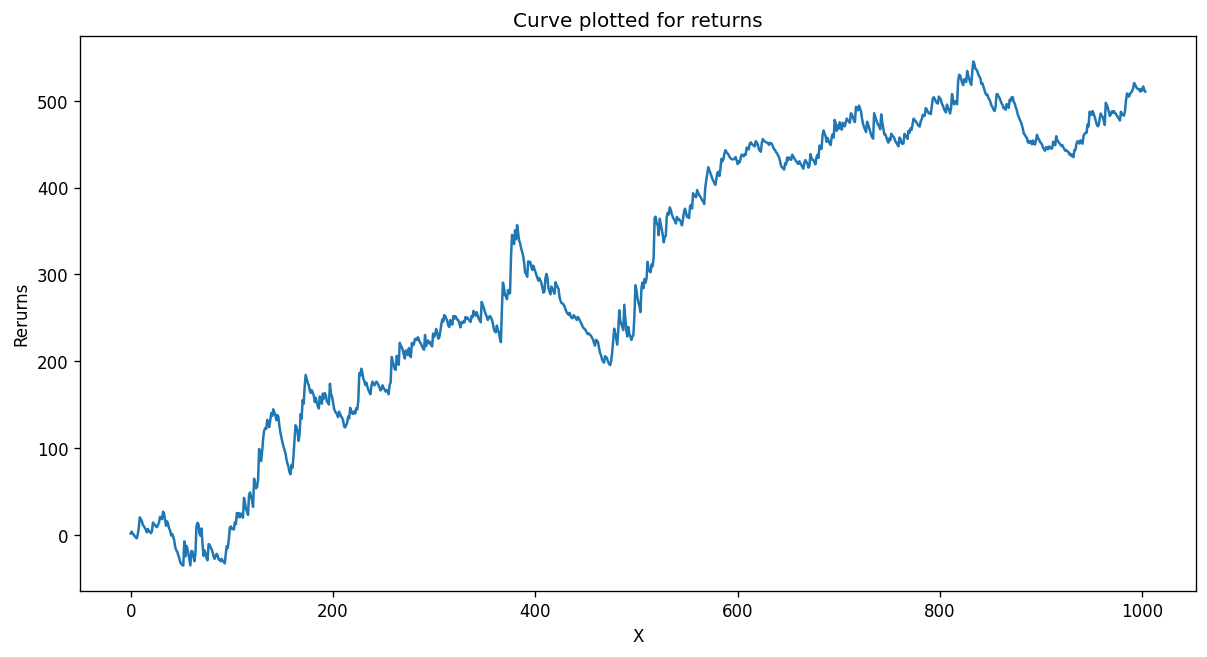

In [27]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()